In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings 
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers



/home/nikhil/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nikhil/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nikhil/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nikhil/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
# set random seed and percentage of test data
RANDOM_SEED = 314  # used to help randomly select the data points
TEST_PCT = 0.2  # 20% of the data

rcParams['figure.figsize'] = 14, 8.7  # Golden Mean
LABELS = ["Normal", "Fraud"]
sns.set(style='white', font_scale=1.75)

The data is reduced using PCA to maintain privacy. The columns Amount, time and class are retained as it is.

In [3]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Check for null values


In [4]:
df.isnull().values.any() 

False

In [5]:
classDistribution = df["Class"].value_counts()
# 0 is normal, 1 is fraud

print(classDistribution)

0    284315
1       492
Name: Class, dtype: int64


Let's get a visual confirmation of the unbalanced data in this fraud dataset.



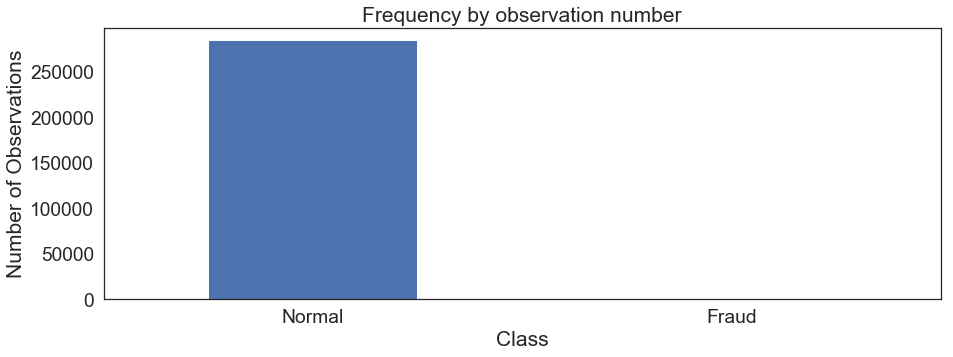

In [6]:
# plt.bar(classDistribution.index, classDistribution.values, width=0.3, align='center')


classDistribution.plot(kind = 'bar', rot=0, figsize=(15,5))
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

Save normal_df and fraud_df observations into a separate dfs

In [7]:
normal_df = df[df.Class == 0]  
fraud_df = df[df.Class == 1]  

Let's look at some summary statistics and see if there are obvious differences between fraud and normal transactions.

In [8]:
print('Normal data\n', normal_df.Amount.describe(), '\n\nFraud data\n', fraud_df.Amount.describe())

Normal data
 count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64 

Fraud data
 count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


Although the mean is a little higher in the fraud transactions, it is certainly within a standard deviation and so is unlikely to be easy to discriminate in a highly precise manner between the classes with pure statistical methods.

/home/nikhil/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


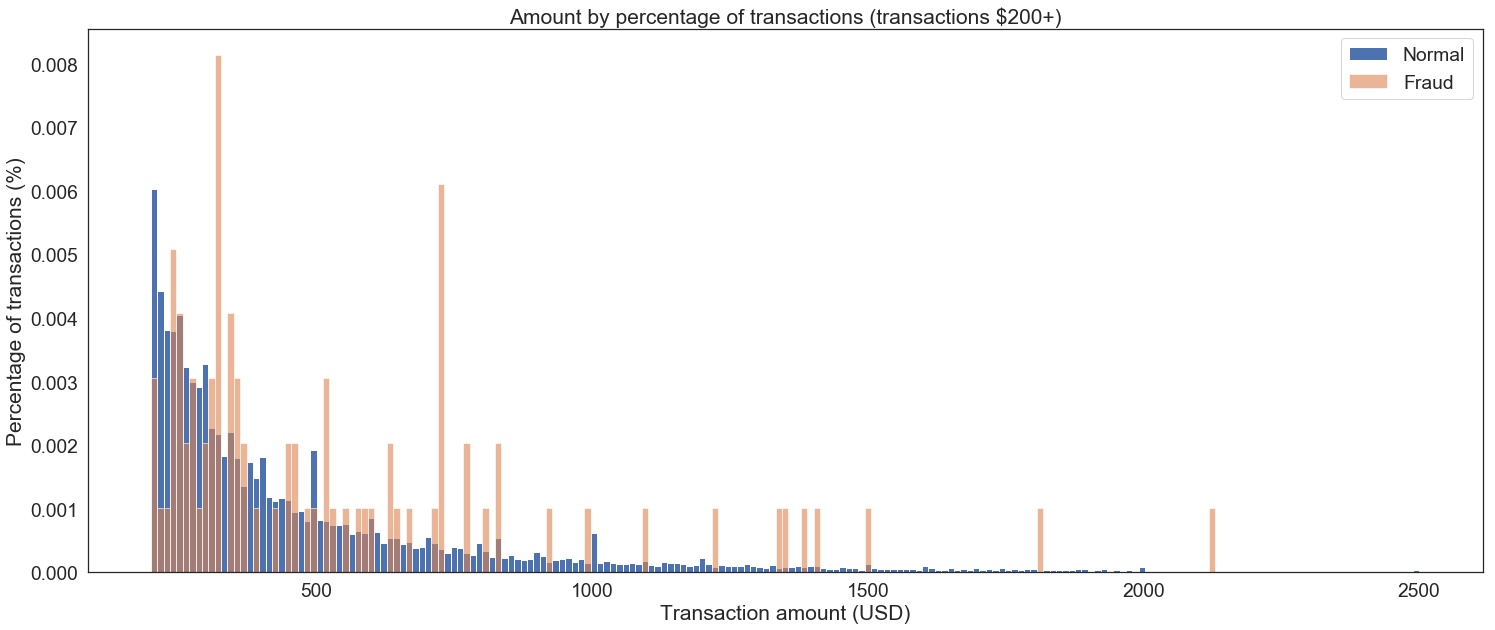

In [9]:
#plot of high value transactions
bins = np.linspace(200, 2500, 200)
plt.figure(figsize=(25,10))
plt.hist(normal_df.Amount, bins, alpha=1, normed=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

The transaction amount does not look very informative. Let's look at the time of the day instead.

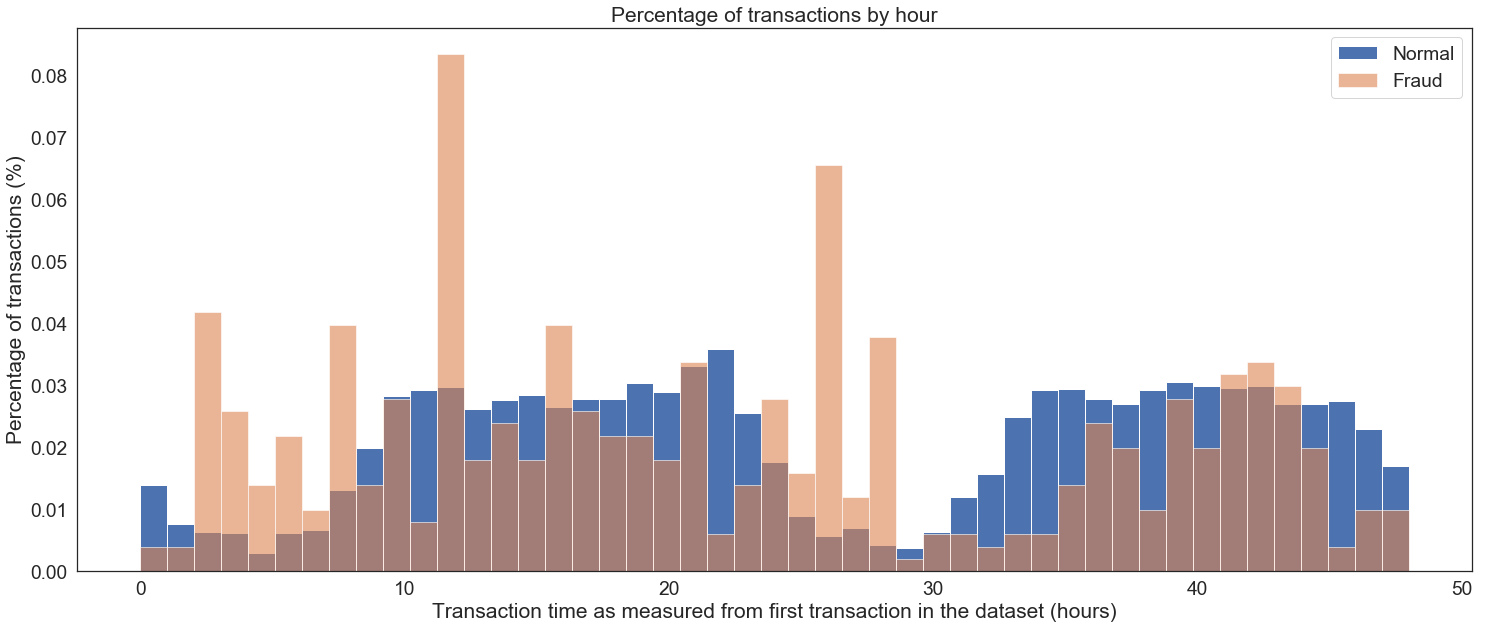

In [10]:
bins = np.linspace(0, 48, 48) #48 hours because we are given 2 days of data
plt.figure(figsize=(25,10))
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, normed=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
#plt.hist((df.Time/(60*60)),bins)
plt.show()

Hour "zero" corresponds to the hour the first transaction happened and not necessarily 12-1am. Given the heavy decrease in normal transactions from hours 1 to 8 and again roughly at hours 24 to 32, it can be assumed that those time correspond to nighttime for this dataset. If this is true, fraud tends to occur at higher rates during the night

Explore the potential interaction between transaction amount and hour to see if any patterns emerge.

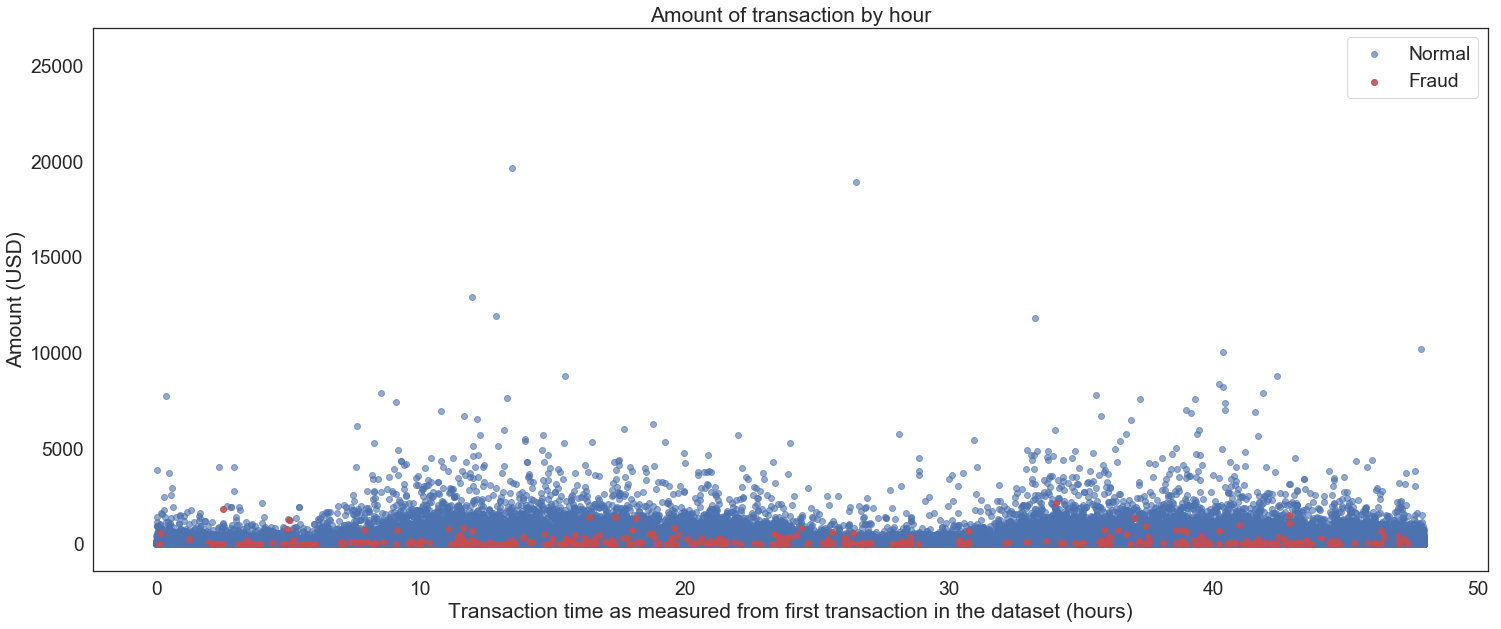

In [11]:
plt.figure(figsize=(25,10))
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud', c='r')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

It would be hard to draw a line that cleanly separates fraud and normal transactions.

Let's create and use Autoencoder:

1. First scale and normalize data - Both time and amount have very different magnitudes, which will likely result in the large magnitude value "washing out" the small magnitude value. 

In [12]:
df_norm = df
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [13]:
train_x, test_x = train_test_split(
    df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0]  # where normal transactions
train_x = train_x.drop(['Class'], axis=1)  # drop the class column

test_y = test_x['Class']  # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)  # drop the class column

train_x = train_x.values  # transform to ndarray
test_x = test_x.values

2. Autoencoder Layer Structure and Parameters - symmetric encoding and decoding layers that are "dense" (e.g. full connected)

In [93]:
nb_epoch = 200
batch_size = 64
input_dim = train_x.shape[1]
encoding_dim1 = 15
encoding_dim2 = 10
hidden_dim = 7
learning_rate = 1e-5

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim1,activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(encoding_dim2,activation="tanh")(encoder)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim2, activation='tanh')(encoder)
decoder = Dense(encoding_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [94]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 30)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_55 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_56 (Dense)             (None, 7)                 77        
_________________________________________________________________
dense_57 (Dense)             (None, 10)                80        
_________________________________________________________________
dense_58 (Dense)             (None, 15)                165       
_________________________________________________________________
dense_59 (Dense)             (None, 30)                480       
Total para

Now we set up the actual run including checkpoints and the tensorboard.

In [95]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 227468 samples, validate on 56962 samples
Epoch 1/200
227468/227468 [==============================] - 10s 45us/step - loss: 0.8193 - acc: 0.5489 - val_loss: 0.7948 - val_acc: 0.6429
Epoch 2/200
227468/227468 [==============================] - 10s 45us/step - loss: 0.7464 - acc: 0.6554 - val_loss: 0.7630 - val_acc: 0.6723
Epoch 3/200
227468/227468 [==============================] - 10s 45us/step - loss: 0.7204 - acc: 0.6860 - val_loss: 0.7468 - val_acc: 0.6947
Epoch 4/200
227468/227468 [==============================] - 10s 44us/step - loss: 0.7105 - acc: 0.6996 - val_loss: 0.7409 - val_acc: 0.7066
Epoch 5/200
227468/227468 [==============================] - 10s 44us/step - loss: 0.7045 - acc: 0.7087 - val_loss: 0.7359 - val_acc: 0.7131
Epoch 6/200
227468/227468 [==============================] - 10s 45us/step - loss: 0.7007 - acc: 0.7136 - val_loss: 0.7354 - val_acc: 0.7157
Epoch 7/200
227468/227468 [==============================] - 10s 45us/step - loss: 0.6981 - acc: 0.7156

227468/227468 [==============================] - 10s 43us/step - loss: 0.6771 - acc: 0.7212 - val_loss: 0.7110 - val_acc: 0.7192
Epoch 59/200
227468/227468 [==============================] - 10s 43us/step - loss: 0.6762 - acc: 0.7213 - val_loss: 0.7135 - val_acc: 0.6971
Epoch 60/200
227468/227468 [==============================] - 10s 43us/step - loss: 0.6762 - acc: 0.7205 - val_loss: 0.7100 - val_acc: 0.7152
Epoch 61/200
227468/227468 [==============================] - 10s 44us/step - loss: 0.6760 - acc: 0.7208 - val_loss: 0.7089 - val_acc: 0.7182
Epoch 62/200
227468/227468 [==============================] - 10s 43us/step - loss: 0.6762 - acc: 0.7213 - val_loss: 0.7102 - val_acc: 0.7148
Epoch 63/200
227468/227468 [==============================] - 10s 43us/step - loss: 0.6762 - acc: 0.7211 - val_loss: 0.7095 - val_acc: 0.7160
Epoch 64/200
227468/227468 [==============================] - 10s 44us/step - loss: 0.6761 - acc: 0.7220 - val_loss: 0.7095 - val_acc: 0.7149
Epoch 65/200
227468

227468/227468 [==============================] - 10s 44us/step - loss: 0.6719 - acc: 0.7320 - val_loss: 0.7064 - val_acc: 0.7235
Epoch 116/200
227468/227468 [==============================] - 10s 43us/step - loss: 0.6718 - acc: 0.7316 - val_loss: 0.7065 - val_acc: 0.7274
Epoch 117/200
227468/227468 [==============================] - 10s 43us/step - loss: 0.6722 - acc: 0.7308 - val_loss: 0.7062 - val_acc: 0.7307
Epoch 118/200
227468/227468 [==============================] - 10s 42us/step - loss: 0.6719 - acc: 0.7315 - val_loss: 0.7047 - val_acc: 0.7254
Epoch 119/200
227468/227468 [==============================] - 10s 42us/step - loss: 0.6729 - acc: 0.7299 - val_loss: 0.7064 - val_acc: 0.7277
Epoch 120/200
227468/227468 [==============================] - 10s 44us/step - loss: 0.6719 - acc: 0.7326 - val_loss: 0.7069 - val_acc: 0.7318
Epoch 121/200
227468/227468 [==============================] - 10s 43us/step - loss: 0.6723 - acc: 0.7312 - val_loss: 0.7059 - val_acc: 0.7212
Epoch 122/200

227468/227468 [==============================] - 9s 39us/step - loss: 0.6686 - acc: 0.7332 - val_loss: 0.7068 - val_acc: 0.7337
Epoch 173/200
227468/227468 [==============================] - 9s 40us/step - loss: 0.6690 - acc: 0.7337 - val_loss: 0.7048 - val_acc: 0.7289
Epoch 174/200
227468/227468 [==============================] - 9s 39us/step - loss: 0.6695 - acc: 0.7335 - val_loss: 0.7027 - val_acc: 0.7331
Epoch 175/200
227468/227468 [==============================] - 9s 39us/step - loss: 0.6687 - acc: 0.7332 - val_loss: 0.7036 - val_acc: 0.7325
Epoch 176/200
227468/227468 [==============================] - 8s 37us/step - loss: 0.6686 - acc: 0.7336 - val_loss: 0.7098 - val_acc: 0.7246
Epoch 177/200
227468/227468 [==============================] - 9s 38us/step - loss: 0.6688 - acc: 0.7328 - val_loss: 0.7014 - val_acc: 0.7333
Epoch 178/200
227468/227468 [==============================] - 9s 40us/step - loss: 0.6689 - acc: 0.7332 - val_loss: 0.7086 - val_acc: 0.7199
Epoch 179/200
227468

In [96]:
# Lets load the saved model itself
autoencoder = load_model('autoencoder_fraud.h5')

This architecture is too simple relative to complex financial data and that overall performance could be improved by adding more hidden layers. More hidden layers would allow this network to encode more complex relationships between the input features.

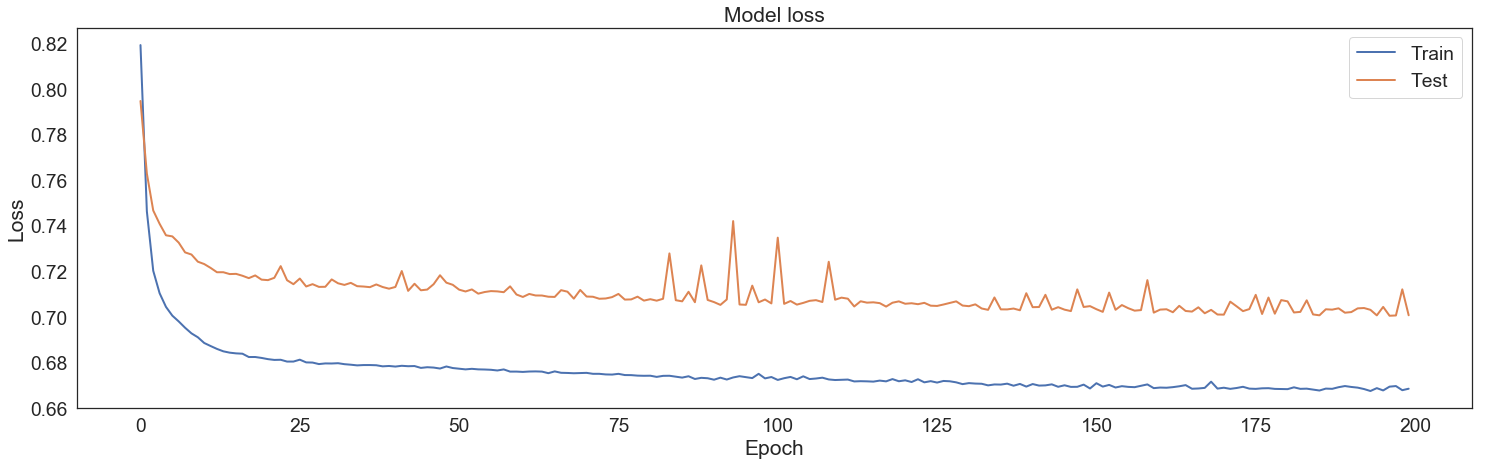

In [97]:
plt.figure(figsize=(25,7))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [98]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.696133,0.002019
std,3.038163,0.044887
min,0.034678,0.000000
25%,0.235459,0.000000
50%,0.378703,0.000000
75%,0.600687,0.000000
max,192.545091,1.000000


Since we have an imbalanced data set Receiver operating characteristic curves are somewhat less useful. Why? Because you can generate a pretty good-looking curve by just simply guessing everything is the normal case because there are so proportionally few cases of fraud.

In [99]:
thresholds.shape

(300,)

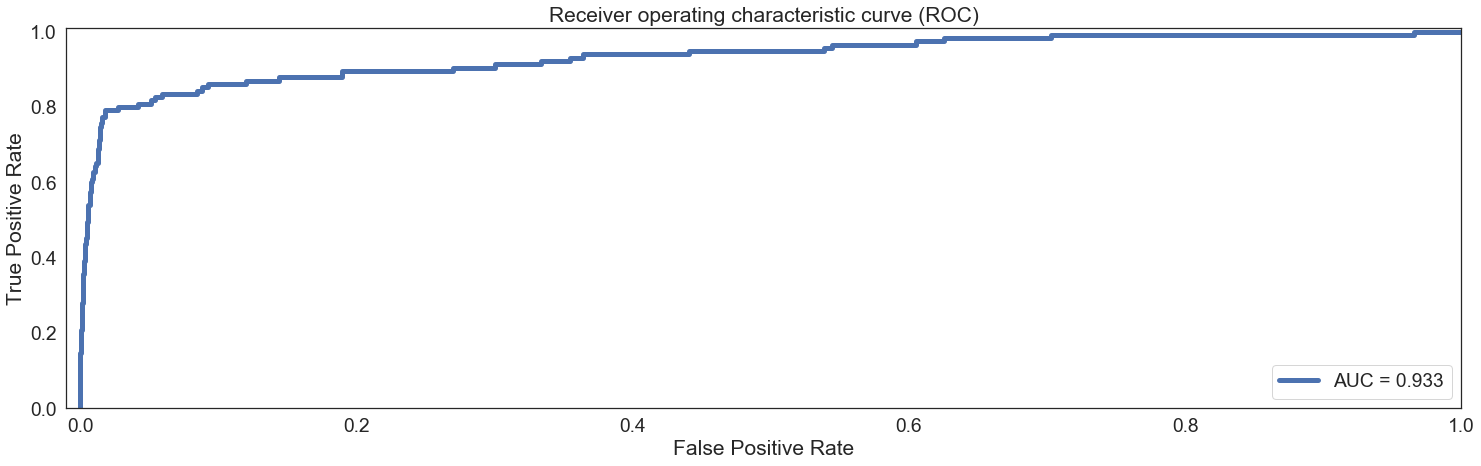

In [100]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(
    error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)
plt.figure(figsize=(25,7))
plt.plot(
    false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f' % roc_auc)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Let's look at recall vs. precision to see the trade-off between the two.

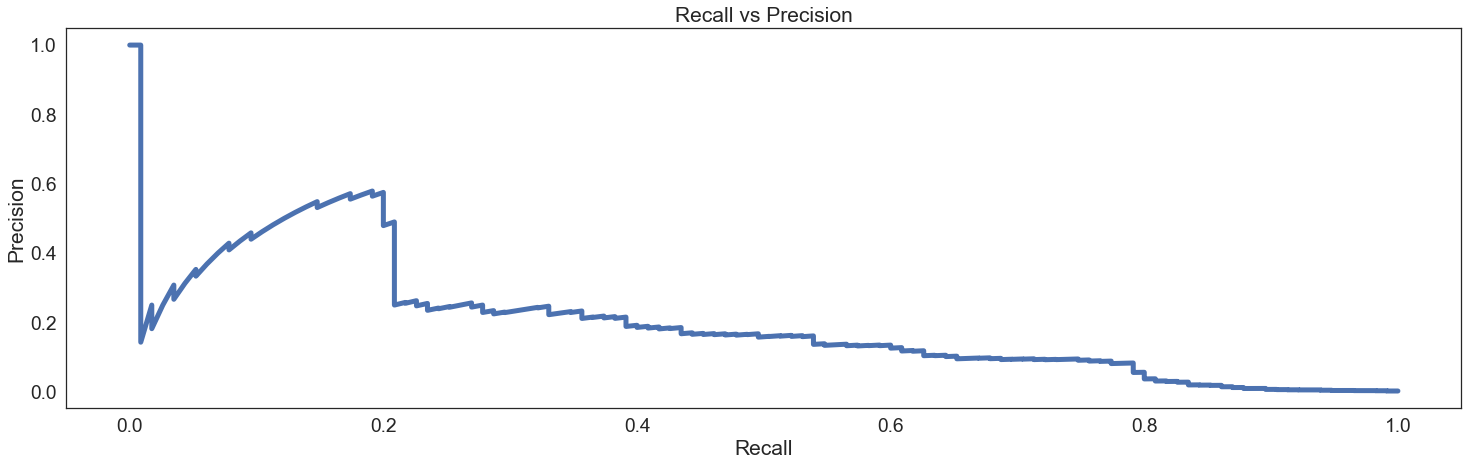

In [101]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, 
                                                    error_df.Reconstruction_error)
plt.figure(figsize=(25,7))
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

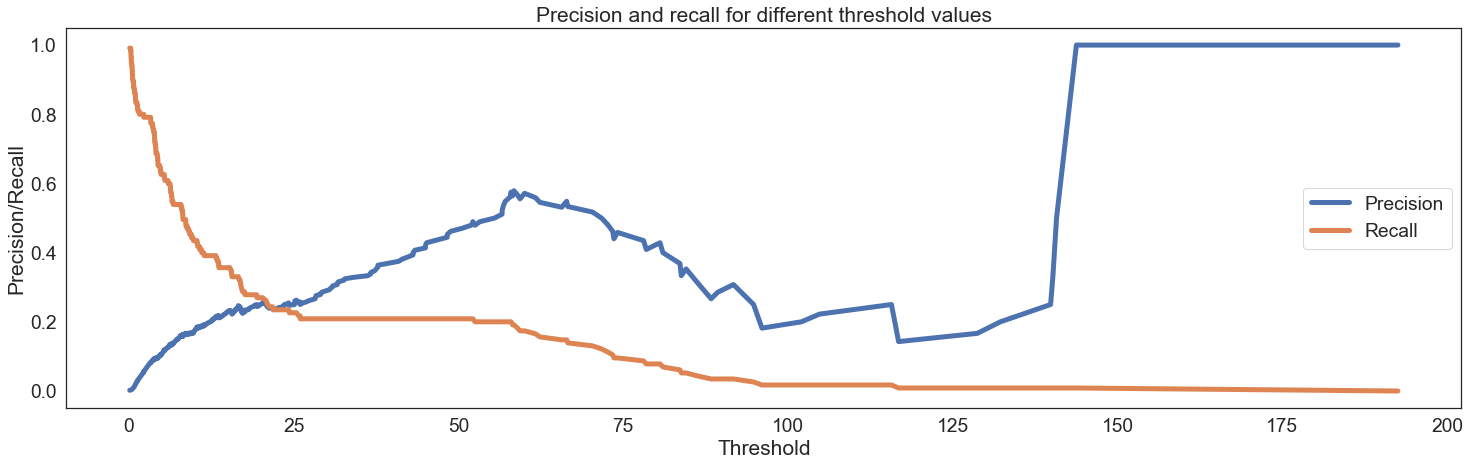

In [102]:
plt.figure(figsize=(25,7))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Reconstruction Error vs Threshold Check


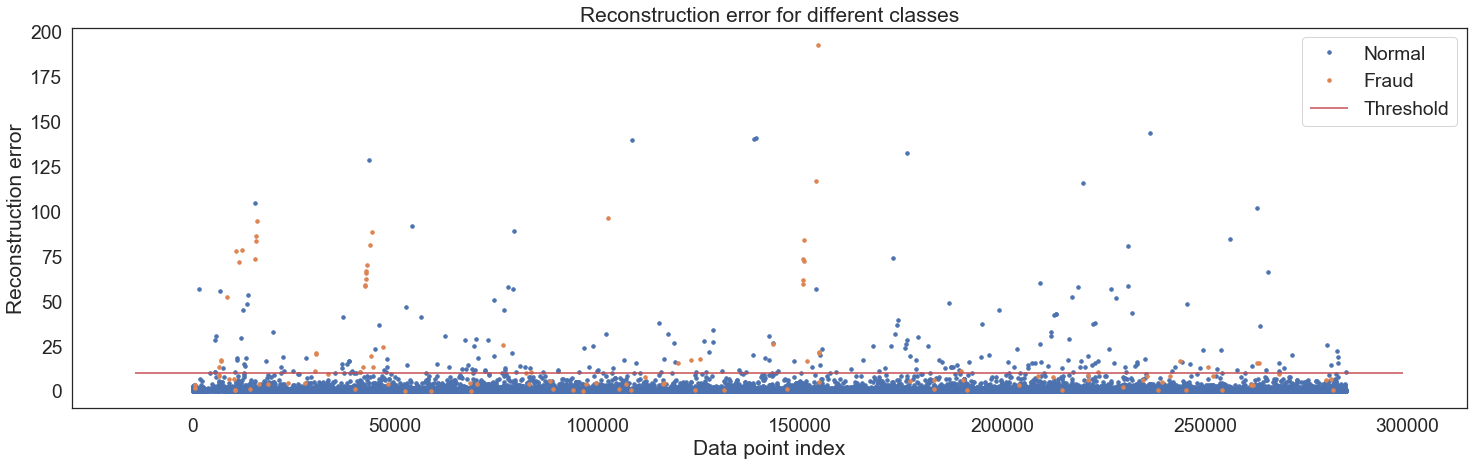

In [103]:
threshold_fixed = 10
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(25,7))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Confusion Matrix


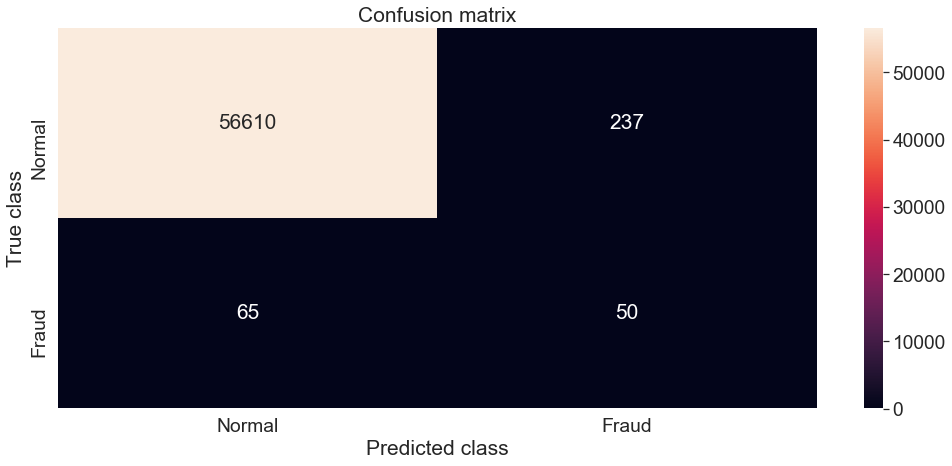

In [104]:
pred_y = [
    1 if e > threshold_fixed else 0
    for e in error_df.Reconstruction_error.values
]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(17, 7))
sns.heatmap(
    conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# TODO: Change the way threhold value is selected.